In [73]:
# Feel free to import any other libraries and modules.
import numpy as np
import matplotlib.pyplot as plt
import torch
from torchvision import datasets, transforms
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from torch import nn

# Part One: Optimization Algorithms
## 1. Gradient Descent
The Gradient Descent (GD) algorithm finds the minimum of a given
function by taking small steps along the function's gradient:

>$\Theta \leftarrow \Theta_0$

>**while** stop condition not met **do**

>$~~~~$$\Theta \leftarrow \Theta - \alpha \nabla_\Theta f(\Theta)$

>**end while**

where $f$ is the function to minimize, $\nabla_\Theta f(\Theta)$
denotes $f$'s gradient at $\Theta$ and $\alpha$ is the learning rate.

**Task1:** Implement the GD algorithm as a function:

  \begin{equation}
      \Theta_{opt} = \text{GD}(f, \Theta_0, \alpha, \rho)
  \end{equation}
where $f$ is a function returning the cost and its gradient with respect to parameter vector $\Theta$, $\Theta_0$ is the initial value, and $\alpha$
is the learning rate. You can assume that $\alpha$. remains constant during the optimization. $\rho$ is stop condition. \\
Then, use the GD algorithm to find the optimum of the [Rosenbrock function](https://en.wikipedia.org/wiki/Rosenbrock_function) (Consider $a=1, b=100$).
 \\
Also, plot the values found by GD at subsequent iterations.

## 2. Newton's Method
Newton's method is an iterative optimization algorithm used to find the minimum of a function.
The basic update step in Newton's method is given by:

\begin{equation}
\Theta = \Theta - H^{-1} \cdot \nabla f(\Theta)
\end{equation}


Where  $ H $ is the Hessian matrix of the function at $ \Theta $, and $ H^{-1} $ is the inverse of the Hessian matrix, used to adjust the step size and direction more accurately than just using the gradient alone (as done in gradient descent).

#### Line Search
Sometimes, Newton's method may take too large of a step, which can lead to divergence. To prevent this, a simple **line search** is used. This reduces the step size $ \alpha $ if the function value doesn't improve after the step.

Steps:
1. Compute the gradient and Hessian matrix at the current point.
2. Calculate the step direction by multiplying the inverse of the Hessian with the gradient.
3. Update the point by subtracting the step from the current point.
4. If the function value doesn't improve, reduce the step size $ \alpha $.
5. Repeat until the gradient becomes sufficiently small (close to zero), indicating convergence.



**Task2:** Implement Newton's method and compare it with the gradient descent. You will also need to implement a line search alogithm, e.g. (https://en.wikipedia.org/wiki/Backtracking_line_search) and make sure that the Newton's direction is indeed one along which the function is minimized.


In [74]:
def rosenbrock(x):
    """Returns the value and gradient of Rosenbrock's function at x: 2d vector"""
    val = (1 - x[0])**2 + 100 * (x[1] - x[0]**2)**2
    dv_dx0 = -2 * (1 - x[0]) - 400 * x[0] * (x[1] - x[0]**2)
    dv_dx1 = 200 * (x[1] - x[0]**2)
    grad = np.array([dv_dx0, dv_dx1])

    return val, grad

def rosenbrock_hessian(x):
    """Returns the value, gradient and hessian of Rosenbrock's function at x: 2d vector"""
    val, grad = rosenbrock(x)

    # Hessian matrix components
    d2v_dx0x0 = 2 - 400 * (x[1] - 3 * x[0]**2)
    d2v_dx0x1 = -400 * x[0]
    d2v_dx1x0 = -400 * x[0]
    d2v_dx1x1 = 200

    # Hessian matrix
    hessian = np.array([[d2v_dx0x0, d2v_dx0x1],
                        [d2v_dx1x0, d2v_dx1x1]])

    return val, grad, hessian

def GD(f, theta0, alpha, stop_tolerance=1e-10, max_steps=1000000):
    """Runs gradient descent algorithm on f."""
    history = []
    theta = theta0
    step = 0

    while step < max_steps:
        val, grad = f(theta)
        history.append((theta, (val, grad)))
        
        # Update rule
        theta = theta - alpha * grad
        
        # Check for stopping condition
        if np.linalg.norm(grad) < stop_tolerance:
            break
        
        step += 1

    return theta, history


Found optimum at [1. 1.] in 54320 steps (true minimum is at [1,1])


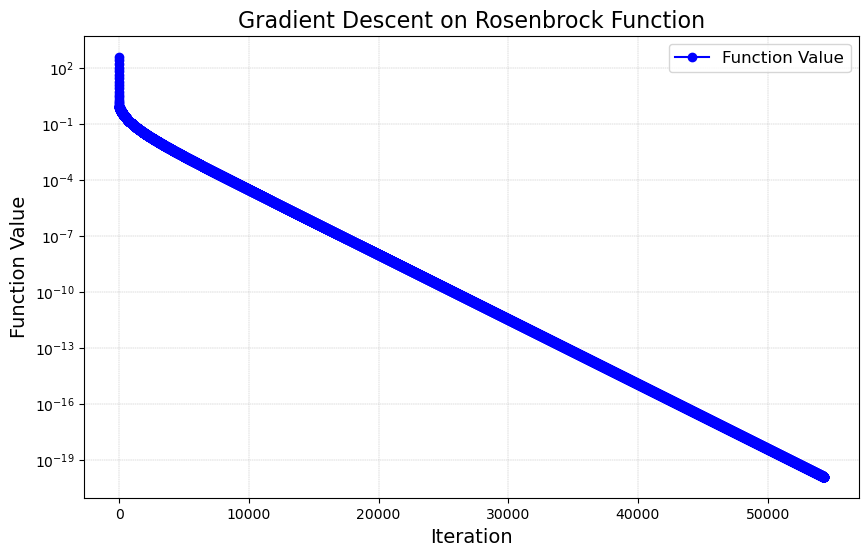

In [75]:
# Find the optimum of rosenbrock function

X0 = [0., 2.]
Xopt, Xhist = GD(rosenbrock, X0, alpha=1e-3, stop_tolerance=1e-10, max_steps=1e6)

print("Found optimum at %s in %d steps (true minimum is at [1,1])" % (Xopt, len(Xhist)))

# Plot how the value changes over iterations
values = [val for _, (val, _) in Xhist]

plt.figure(figsize=(10, 6))
plt.plot(values, marker='o', color='b', label='Function Value')
plt.yscale('log')
plt.xlabel('Iteration', fontsize=14)
plt.ylabel('Function Value', fontsize=14)
plt.title('Gradient Descent on Rosenbrock Function', fontsize=16)
plt.grid(True, which='both', linestyle='--', linewidth=0.3)
plt.legend(fontsize=12)
plt.show()

In [76]:
def Newton(f, theta0, alpha=1, stop_tolerance=1e-10, max_steps=1000000):
    """Performs Newton's optimization method with a simple line search."""
    theta = np.array(theta0, dtype=np.float64)  # Ensure theta is a NumPy array for operations
    history = []

    for step in range(max_steps):
        # Evaluate function value, gradient, and hessian at current theta
        val, grad, hessian = f(theta)
        history.append((theta.copy(), val, grad))

        # Check stopping criterion
        if np.linalg.norm(grad) < stop_tolerance:
            break

        # Newton update: theta = theta - alpha * H^-1 * grad
        try:
            # Invert the Hessian
            hessian_inv = np.linalg.inv(hessian)
            theta = theta - alpha * hessian_inv @ grad
        except np.linalg.LinAlgError:
            # If Hessian is singular, stop the method
            print("Hessian is singular. Stopping optimization.")
            break

    return theta, history

# Test Newton's method on the Rosenbrock function
X0 = [0., 2.]  # Initial guess
Xopt, Xhist = Newton(rosenbrock_hessian, X0)

print("Found optimum at %s (true minimum is at [1,1])" % Xopt)



Found optimum at [1. 1.] (true minimum is at [1,1])


# Part two: MLP for MNIST Classification
In this part, we are going to use `PyTorch`. If you want to become more familiar with it, check this resource: https://www.learnpytorch.io/

#### In this homework, you need to
- implement SGD optimizer (`./optimizer.py`)
- implement forward and backward for FCLayer (`layers.py`)
- implement forward and backward for SigmoidLayer (`layers.py`)
- implement forward and backward for ReLULayer (`layers.py`)
- implement forward and backward for DropoutLayer (`layers.py`)
- implement train and test process (`solver.py`)

In [77]:
from layers import FCLayer, SigmoidLayer, ReLULayer
from solver import train, test
from optimizer import SGD

In [78]:
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [79]:
# Load MNIST dataset

# Converts PIL image to tensor and scales to [0, 1] and flatten it
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.view(-1)),
])

# Load MNIST dataset with the defined transform
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# One-hot encoding for labels
def decode_label(label, num_classes=10):
    return torch.nn.functional.one_hot(torch.tensor(label), num_classes=num_classes).float()

# Preprocess labels and combine with transformed images
y_train = [decode_label(label) for _, label in train_dataset]
y_test = [decode_label(label) for _, label in test_dataset]

# Convert the data into tensor datasets for training and testing
train_dataset = TensorDataset(torch.stack([img for img, _ in train_dataset]), torch.stack(y_train))
test_dataset = TensorDataset(torch.stack([img for img, _ in test_dataset]), torch.stack(y_test))

# Create data loaders
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)



for inputs, labels in train_dataloader:
    print(f"Sample inputs: {inputs[0]}")  # Print the first sample in the batch
    print(f"Sample labels: {labels[0]}")  # Print the first label in the batch
    if torch.isnan(inputs).any() or torch.isnan(labels).any():
        print("Found NaN values in the data!")
    if torch.isinf(inputs).any() or torch.isinf(labels).any():
        print("Found Inf values in the data!")
    break  # Only check one batch


Sample inputs: tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0

In [80]:
num_epoch = 20

criterion = nn.MSELoss()

# Build MLP with FCLayer and SigmoidLayer you've implemented in layers.py
sigmoidMLP = nn.Sequential(
    FCLayer(784, 128),
    SigmoidLayer(),
    FCLayer(128, 10)
)

# Initialize optimizer you've implemented in optimizer.py
sgd = SGD(params=sigmoidMLP.parameters(), learning_rate=0.01)

# Train the model using train function you've implemented in solver.py
sigmoidMLP = train(sigmoidMLP, criterion, sgd, train_dataloader, num_epoch, device=device)


Epoch [0] Average training loss: 0.0753, Average training accuracy: 0.5267

Epoch [1] Average training loss: 0.0547, Average training accuracy: 0.7655

Epoch [2] Average training loss: 0.0499, Average training accuracy: 0.8018

Epoch [3] Average training loss: 0.0476, Average training accuracy: 0.8169

Epoch [4] Average training loss: 0.0461, Average training accuracy: 0.8259

Epoch [5] Average training loss: 0.0451, Average training accuracy: 0.8318

Epoch [6] Average training loss: 0.0443, Average training accuracy: 0.8366

Epoch [7] Average training loss: 0.0437, Average training accuracy: 0.8396

Epoch [8] Average training loss: 0.0433, Average training accuracy: 0.8429

Epoch [9] Average training loss: 0.0429, Average training accuracy: 0.8443

Epoch [10] Average training loss: 0.0425, Average training accuracy: 0.8466

Epoch [11] Average training loss: 0.0422, Average training accuracy: 0.8469

Epoch [12] Average training loss: 0.0419, Average training accuracy: 0.8485

Epoch [1

In [81]:
# Test your model using test function you've implemented in solver.py
test(sigmoidMLP, test_dataloader, device)

The test accuracy is 0.8639.



In [82]:
# Build MLP with FCLayer and ReLULayer
reluMLP = nn.Sequential(
    FCLayer(784, 128),
    ReLULayer(),
    FCLayer(128, 10)
)

# Initialize optimizer
sgd = SGD(reluMLP.parameters(), learning_rate=0.01)

# Train the model
reluMLP = train(reluMLP, criterion, sgd, train_dataloader, num_epoch, device=device)


Epoch [0] Average training loss: 0.0704, Average training accuracy: 0.6361

Epoch [1] Average training loss: 0.0459, Average training accuracy: 0.8162

Epoch [2] Average training loss: 0.0394, Average training accuracy: 0.8529

Epoch [3] Average training loss: 0.0355, Average training accuracy: 0.8712

Epoch [4] Average training loss: 0.0327, Average training accuracy: 0.8821

Epoch [5] Average training loss: 0.0306, Average training accuracy: 0.8902

Epoch [6] Average training loss: 0.0289, Average training accuracy: 0.8953

Epoch [7] Average training loss: 0.0275, Average training accuracy: 0.8999

Epoch [8] Average training loss: 0.0264, Average training accuracy: 0.9038

Epoch [9] Average training loss: 0.0254, Average training accuracy: 0.9073

Epoch [10] Average training loss: 0.0245, Average training accuracy: 0.9104

Epoch [11] Average training loss: 0.0238, Average training accuracy: 0.9129

Epoch [12] Average training loss: 0.0232, Average training accuracy: 0.9156

Epoch [1

In [83]:
# Test the model
test(reluMLP, test_dataloader, device)

The test accuracy is 0.9290.



### Overfit the model
Try to overfit the reluMLP model. You can make the model as complex as you like, use subset of the data for training or any other approach you want.
Then add **DropoutLayer** to your model in order to reduce overfitting problem.

In [ ]:
# Adjusted Model
class AdjustedNN(nn.Module):
    def __init__(self):
        super(AdjustedNN, self).__init__()
        self.fc1 = FCLayer(784, 256)
        self.relu1 = ReLULayer()
        self.fc2 = FCLayer(256, 128)
        self.relu2 = ReLULayer()
        self.fc3 = FCLayer(128, 10)  # Output layer for 10 classes

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.fc3(x)
        return x

# Instantiate the model
reluImproved = AdjustedNN()
reluImproved.to(device)

# Ensure valid subset size
subset_size = 2000
dataset_size = len(train_dataset)
if subset_size > dataset_size:
    subset_size = dataset_size

subset_indices = np.random.choice(dataset_size, subset_size, replace=False)
subset_train_dataset = torch.utils.data.Subset(train_dataset, subset_indices)
subset_train_dataloader = DataLoader(subset_train_dataset, batch_size=64, shuffle=True)

# Define CrossEntropyLoss and optimizer
criterion = nn.CrossEntropyLoss()
sgd = SGD(params=reluImproved.parameters(), learning_rate=0.001)

# Train the model
reluImproved.train()
num_epochs = 20
for epoch in range(num_epochs):
    epoch_loss = 0
    correct = 0
    total = 0

    for batch in subset_train_dataloader:
        inputs, targets = batch
        inputs, targets = inputs.to(device), targets.to(device)

        # Convert one-hot targets to class indices if necessary
        if targets.ndimension() == 2:
            targets = torch.argmax(targets, dim=1)

        # Forward pass
        outputs = reluImproved(inputs)

        # Compute loss
        loss = criterion(outputs, targets)

        # Backward pass and optimization
        sgd.zero_grad()
        loss.backward()
        sgd.step()

        # Accumulate loss and accuracy
        epoch_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += (predicted == targets).sum().item()

    avg_loss = epoch_loss / len(subset_train_dataloader)
    avg_accuracy = correct / total

    print(f"Epoch [{epoch}] Average training loss: {avg_loss:.4f}, Average training accuracy: {avg_accuracy:.4f}")

# Evaluate the model on the test set
reluImproved.eval()
batch_test_acc = []

with torch.no_grad():
    for inputs, targets in test_dataloader:
        inputs, targets = inputs.to(device), targets.to(device)

        # Convert one-hot targets to class indices if necessary
        if targets.ndimension() == 2:
            targets = torch.argmax(targets, dim=1)

        outputs = reluImproved(inputs)
        _, predicted = outputs.max(1)
        accuracy = (predicted == targets).float().mean().item()
        batch_test_acc.append(accuracy)

test_accuracy = torch.tensor(batch_test_acc).mean().item()
print(f"The test accuracy is {test_accuracy:.4f}.")

Epoch [0] Average training loss: 0.1282, Average training accuracy: 0.1387
Epoch [1] Average training loss: 0.0974, Average training accuracy: 0.1787
Epoch [2] Average training loss: 0.0909, Average training accuracy: 0.2441
Epoch [3] Average training loss: 0.0858, Average training accuracy: 0.3145
Epoch [4] Average training loss: 0.0816, Average training accuracy: 0.4053
Epoch [5] Average training loss: 0.0783, Average training accuracy: 0.4746
Epoch [6] Average training loss: 0.0749, Average training accuracy: 0.5273
Epoch [7] Average training loss: 0.0724, Average training accuracy: 0.5615
Epoch [8] Average training loss: 0.0699, Average training accuracy: 0.6025
Epoch [9] Average training loss: 0.0679, Average training accuracy: 0.6201
Epoch [10] Average training loss: 0.0657, Average training accuracy: 0.6348
Epoch [11] Average training loss: 0.0640, Average training accuracy: 0.6523
Epoch [12] Average training loss: 0.0624, Average training accuracy: 0.6777
Epoch [13] Average tra

### Overfit the model
Try to overfit the reluMLP model. You can make the model as complex as you like, use subset of the data for training or any other approach you want.
Then add **DropoutLayer** to your model in order to reduce overfitting problem.

In [ ]:
from layers import DropoutLayer

# Overfitted Model
class OverfitNN(nn.Module):
    def __init__(self):
        super(OverfitNN, self).__init__()
        self.fc1 = FCLayer(784, 512)
        self.relu1 = ReLULayer()
        self.fc2 = FCLayer(512, 256)
        self.relu2 = ReLULayer()
        self.fc3 = FCLayer(256, 128)
        self.relu3 = ReLULayer()
        self.fc4 = FCLayer(128, 10)  # Output layer

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.fc3(x)
        x = self.relu3(x)
        x = self.fc4(x)
        return x

# Add Dropout Layer to reduce overfitting
class DropoutNN(nn.Module):
    def __init__(self):
        super(DropoutNN, self).__init__()
        self.fc1 = FCLayer(784, 512)
        self.relu1 = ReLULayer()
        self.dropout1 = DropoutLayer(0.5)
        self.fc2 = FCLayer(512, 256)
        self.relu2 = ReLULayer()
        self.dropout2 = DropoutLayer(0.5)
        self.fc3 = FCLayer(256, 128)
        self.relu3 = ReLULayer()
        self.dropout3 = DropoutLayer(0.5)
        self.fc4 = FCLayer(128, 10)  # Output layer

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.dropout1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.dropout2(x)
        x = self.fc3(x)
        x = self.relu3(x)
        x = self.dropout3(x)
        x = self.fc4(x)
        return x

# Subset the dataset to induce overfitting
subset_size = 500  # Small subset to enforce overfitting
dataset_size = len(train_dataset)
if subset_size > dataset_size:
    subset_size = dataset_size
subset_indices = np.random.choice(dataset_size, subset_size, replace=False)
subset_train_dataset = torch.utils.data.Subset(train_dataset, subset_indices)
subset_train_dataloader = DataLoader(subset_train_dataset, batch_size=32, shuffle=True)


for epoch in range(20):
    epoch_loss = 0
    correct = 0
    total = 0
    for inputs, targets in subset_train_dataloader:
        inputs, targets = inputs.to(device), targets.to(device)

        if targets.ndimension() == 2:
            targets = torch.argmax(targets, dim=1)

        outputs = overfit_model(inputs)
        loss = criterion(outputs, targets)
        sgd.zero_grad()
        loss.backward()
        sgd.step()

        epoch_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += (predicted == targets).sum().item()

    avg_loss = epoch_loss / len(subset_train_dataloader)
    avg_accuracy = correct / total
    print(f"Epoch [{epoch}] Average training loss: {avg_loss:.4f}, Average training accuracy: {avg_accuracy:.4f}")



# Train dropout model to reduce overfitting
dropout_model = DropoutNN()
dropout_model.to(device)
sgd = SGD(params=dropout_model.parameters(), learning_rate=0.01)

dropout_model.train()
for epoch in range(20):
    epoch_loss = 0
    correct = 0
    total = 0
    for inputs, targets in subset_train_dataloader:
        inputs, targets = inputs.to(device), targets.to(device)

        if targets.ndimension() == 2:
            targets = torch.argmax(targets, dim=1)

        outputs = dropout_model(inputs)
        loss = criterion(outputs, targets)
        sgd.zero_grad()
        loss.backward()
        sgd.step()

        epoch_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += (predicted == targets).sum().item()

    avg_loss = epoch_loss / len(subset_train_dataloader)
    avg_accuracy = correct / total
    print(f"Epoch [{epoch}] Average training loss: {avg_loss:.4f}, Average training accuracy: {avg_accuracy:.4f}")

# Test the dropout model
dropout_model.eval()
test(dropout_model, test_dataloader, device)


Epoch [0] Average training loss: 0.1150, Average training accuracy: 0.1564
Epoch [1] Average training loss: 0.0892, Average training accuracy: 0.2339
Epoch [2] Average training loss: 0.0846, Average training accuracy: 0.3121
Epoch [3] Average training loss: 0.0783, Average training accuracy: 0.3754
Epoch [4] Average training loss: 0.0732, Average training accuracy: 0.4308
Epoch [5] Average training loss: 0.0714, Average training accuracy: 0.4795
Epoch [6] Average training loss: 0.0703, Average training accuracy: 0.5177
Epoch [7] Average training loss: 0.0682, Average training accuracy: 0.5483
Epoch [8] Average training loss: 0.0660, Average training accuracy: 0.5859
Epoch [9] Average training loss: 0.0642, Average training accuracy: 0.6089
Epoch [10] Average training loss: 0.0623, Average training accuracy: 0.6334
Epoch [11] Average training loss: 0.0608, Average training accuracy: 0.6532
Epoch [12] Average training loss: 0.0595, Average training accuracy: 0.6698
Epoch [13] Average tr